In [1]:
import sys
import os
from pathlib import Path
import importlib

# Add project root to path
PROJECT_ROOT = Path('/mnt/home/mlee1/vdm_BIND')
sys.path.insert(0, str(PROJECT_ROOT))

# Force reload of bind module to pick up any changes
# This is important if workflow_utils.py was modified since kernel start
for mod_name in list(sys.modules.keys()):
    if mod_name.startswith('bind') or mod_name.startswith('vdm'):
        del sys.modules[mod_name]

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import joblib

# Import from our codebase (fresh import after clearing cache)
from bind.workflow_utils import ConfigLoader, ModelManager, sample, load_normalization_stats
from vdm.astro_dataset import get_astro_data

# Setup publication-quality plotting
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.figsize': (12, 8),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

# Output directory for figures
FIGURE_DIR = PROJECT_ROOT / 'analysis' / 'figures' / 'training'
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
print(f"Figures will be saved to: {FIGURE_DIR}")

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/sw/nix/store/6qvrglgqdpwhbw9zv2nh07fpd7a4wq31-py-torchvision-0.15.2/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Figures will be saved to: /mnt/home/mlee1/vdm_BIND/analysis/figures/training


## Configuration

Select the model type and config to use.

In [ ]:
# ============================================================================
# MODEL CONFIGURATION - MODIFY THIS SECTION
# ============================================================================

# Model type: 'clean' (3-channel joint), 'triple' (3 separate VDMs), 'ddpm' (score_models), or 'interpolant' (flow matching)
MODEL_TYPE = 'interpolant'  # Options: 'clean', 'triple', 'ddpm', 'interpolant'

# Config file path - auto-select based on MODEL_TYPE or set manually
if MODEL_TYPE == 'clean':
    CONFIG_PATH = PROJECT_ROOT / 'configs' / 'clean_vdm_aggressive_stellar.ini'
elif MODEL_TYPE == 'triple':
    CONFIG_PATH = PROJECT_ROOT / 'configs' / 'clean_vdm_triple.ini'
elif MODEL_TYPE == 'ddpm':
    CONFIG_PATH = PROJECT_ROOT / 'configs' / 'ddpm.ini'
elif MODEL_TYPE == 'interpolant':
    CONFIG_PATH = PROJECT_ROOT / 'configs' / 'interpolant.ini'
else:
    raise ValueError(f"Unknown MODEL_TYPE: {MODEL_TYPE}. Use 'clean', 'triple', 'ddpm', or 'interpolant'")

# Number of test samples to visualize
N_SAMPLES = 5

# Number of stochastic realizations per sample
N_REALIZATIONS = 4

# Sampling steps (used for DDPM and interpolant)
SAMPLING_STEPS = 50  # 50 for interpolant, 1000 for DDPM

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Model type: {MODEL_TYPE}")
print(f"Config: {CONFIG_PATH}")
print(f"Device: {DEVICE}")
if MODEL_TYPE in ['ddpm', 'interpolant']:
    print(f"Sampling steps: {SAMPLING_STEPS}")

Model type: ddpm
Config: /mnt/home/mlee1/vdm_BIND/configs/ddpm.ini
Device: cuda
DDPM sampling steps: 1000


## Load Model and Test Data

In [3]:
# Load configuration
config = ConfigLoader(str(CONFIG_PATH), verbose=True)

# Resolve relative paths to absolute paths
if hasattr(config, 'quantile_path') and config.quantile_path is not None:
    if not os.path.isabs(config.quantile_path):
        config.quantile_path = str(PROJECT_ROOT / config.quantile_path)
        print(f"Resolved quantile_path to: {config.quantile_path}")

print(f"\nModel: {config.model_name}")
print(f"Checkpoint: {config.best_ckpt}")

[ConfigLoader] conditioning_channels not in config or None, using default: 1
[ConfigLoader] 🌟 Quantile normalization enabled: data/quantile_normalizer_stellar.pkl
[ConfigLoader] Loaded config from: /mnt/home/mlee1/vdm_BIND/configs/ddpm.ini
[ConfigLoader] Parameters:
  seed: 8
  dataset: IllustrisTNG
  data_root: /mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/train/
  field: gas
  boxsize: 6.25
  batch_size: 16
  accumulate_grad_batches: 4
  num_workers: 8
  cropsize: 128
  max_epochs: 250
  learning_rate: 0.0001
  lr_scheduler: cosine
  architecture: ncsnpp
  nf: 96
  ch_mult: 1,2,4,8
  num_res_blocks: 2
  attention: True
  dropout: 0.1
  sde: vp
  beta_min: 0.1
  beta_max: 20.0
  sigma_min: 0.01
  sigma_max: 50.0
  large_scale_channels: 3
  use_param_conditioning: True
  n_params: 35
  enable_ema: True
  ema_decay: 0.9999
  ema_update_after_step: 1000
  ema_update_every: 1
  quantile_path: data/quantile_normalizer_stellar.pkl
  enable_early_stopping: False
  early_stopping_patience:

In [ ]:
# Load model and test dataloader
# ModelManager now supports 'clean', 'triple', 'ddpm', and 'interpolant' models automatically
print("\nLoading model and test data...")
print(f"Configured model type: {MODEL_TYPE}")

# Check that checkpoint exists
if config.best_ckpt is None:
    raise ValueError(f"No checkpoint found for model {config.model_name}")

# ModelManager.initialize() auto-detects model type from config.model_name or checkpoint
test_loader, model = ModelManager.initialize(config, verbose=True, skip_data_loading=False)

# Detect actual model type (may differ from configured if checkpoint is different)
detected_type = ModelManager.detect_model_type(config, verbose=True)
print(f"Detected model type: {detected_type}")

# IMPORTANT: Verify the model class is correct
model_class = type(model).__name__
print(f"\n>>> Model class loaded: {model_class}")

if detected_type == 'ddpm':
    if model_class == 'DDPMModelWrapper':
        print("✓ Correct model class - using fixed score_models loading")
    elif model_class == 'LightScoreModel':
        print("⚠️  WARNING: Old LightScoreModel detected!")
        print("   The workflow_utils.py may not have been reloaded.")
        print("   Please RESTART KERNEL and re-run all cells.")
    else:
        print(f"⚠️  Unexpected model class: {model_class}")
elif detected_type == 'interpolant':
    if model_class == 'LightInterpolant':
        print("✓ Correct model class - LightInterpolant")
    else:
        print(f"⚠️  Unexpected model class for interpolant: {model_class}")

# Move model to device
model = model.to(DEVICE)
model.eval()

# Get actual DataLoader from DataModule (for all model types)
actual_loader = test_loader.test_dataloader()
print(f"\n✓ Model loaded successfully")
print(f"Test dataset size: {len(test_loader.dataset)}")

# For DDPM/Interpolant models, update sampling steps if specified
if detected_type == 'ddpm' and hasattr(model, 'n_sampling_steps'):
    model.n_sampling_steps = SAMPLING_STEPS
    model.hparams.n_sampling_steps = SAMPLING_STEPS
    print(f"✓ Set DDPM sampling steps to {SAMPLING_STEPS}")
elif detected_type == 'interpolant' and hasattr(model, 'n_sampling_steps'):
    model.n_sampling_steps = SAMPLING_STEPS
    if hasattr(model, 'hparams'):
        model.hparams.n_sampling_steps = SAMPLING_STEPS
    print(f"✓ Set Interpolant sampling steps to {SAMPLING_STEPS}")

Seed set to 8



Loading model and test data...
Configured model type: ddpm
[ModelManager] Detected 'ddpm' model from model_name: ddpm_ncsnpp_vp
[ModelManager] Initializing DDPM/Score Model (direct score_models approach)...
[ModelManager] Using seed: 8
[ModelManager] Checkpoint path: /mnt/home/mlee1/ceph/tb_logs/ddpm_ncsnpp_vp/version_1//checkpoints/epoch-epoch=039-step=51120.ckpt
[ModelManager] Loaded hyperparameters from checkpoint:
  sde: vp
  beta_min: 0.1
  beta_max: 20.0
  sigma_min: 0.01
  sigma_max: 50.0
  learning_rate: 0.0001
  weight_decay: 1e-05
  lr_scheduler: cosine
  ema_decay: 0.9999
  n_sampling_steps: 250
  use_param_conditioning: True
  device: cuda
[ModelManager] DDPM Model Configuration:
  SDE type: vp
  nf: 96, ch_mult: (1, 2, 4, 8)
  Spatial conditioning channels: 4
  Parameter conditioning: True (35 params)
  Sampling steps: 250
[ModelManager] Loaded hyperparameters from checkpoint:
  sde: vp
  beta_min: 0.1
  beta_max: 20.0
  sigma_min: 0.01
  sigma_max: 50.0
  learning_rate: 

/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUANTILE TRANSFORMATION (n_quantiles=10000)
✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading quantile transformer from: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUANTILE TRANSFORMATION (n_quantiles=10000)
[ModelManager] Dataset loaded.
[ModelManager] Detected 'ddpm' model from model_name: ddpm_ncsnpp_vp
Detected model type: ddpm

>>> Model class loaded: DDPMModelWrapper
✓ Correct model class - using fixed score_models l

In [5]:
# Load normalization statistics
norm_stats = load_normalization_stats()

# Check if using quantile normalization for stars
use_quantile = hasattr(config, 'quantile_path') and config.quantile_path is not None
if use_quantile:
    quantile_path = config.quantile_path
    # Resolve relative path if needed
    if not os.path.isabs(quantile_path):
        quantile_path = str(PROJECT_ROOT / quantile_path)
    quantile_transformer = joblib.load(quantile_path)
    print(f"Using quantile normalization for stars: {quantile_path}")
else:
    quantile_transformer = None
    print(f"Using Z-score normalization for all channels")

✓ Loaded DM normalization: mean=9.915499, std=0.467967
✓ Loaded Gas normalization: mean=9.177344, std=0.410510
✓ Loaded Stellar normalization: mean=6.995926, std=1.100350
Using quantile normalization for stars: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl


## Unnormalization Functions

In [6]:
def unnormalize_field(field, channel_idx, norm_stats, quantile_transformer=None):
    """
    Unnormalize a field from normalized space back to physical units.
    
    Args:
        field: Normalized field (can be 2D or higher)
        channel_idx: 0=DM, 1=Gas, 2=Stars
        norm_stats: Dictionary with normalization statistics
        quantile_transformer: Optional quantile transformer for stars
    
    Returns:
        Field in physical units (mass density)
    """
    if channel_idx == 0:  # DM
        mean, std = norm_stats['dm_mag_mean'], norm_stats['dm_mag_std']
    elif channel_idx == 1:  # Gas
        mean, std = norm_stats['gas_mag_mean'], norm_stats['gas_mag_std']
    elif channel_idx == 2:  # Stars
        if quantile_transformer is not None:
            # Quantile inverse transform
            original_shape = field.shape
            field_flat = field.flatten().reshape(-1, 1)
            log_field = quantile_transformer.inverse_transform(field_flat)
            log_field = log_field.reshape(original_shape)
            return 10**log_field - 1
        else:
            mean, std = norm_stats['star_mag_mean'], norm_stats['star_mag_std']
    else:
        raise ValueError(f"Unknown channel index: {channel_idx}")
    
    # Z-score inverse: log_field = field * std + mean
    log_field = field * std + mean
    return 10**log_field - 1


def unnormalize_condition(field, norm_stats):
    """
    Unnormalize DM condition field.
    """
    # Use DM condition stats (different from target DM stats)
    mean = norm_stats.get('dm_condition_mean', norm_stats['dm_mag_mean'])
    std = norm_stats.get('dm_condition_std', norm_stats['dm_mag_std'])
    log_field = field * std + mean
    return 10**log_field - 1

## Load Test Samples and Generate Predictions

In [7]:
# Get a batch of test samples
# test_loader is a DataModule, need to get the actual dataloader
if hasattr(test_loader, 'test_dataloader'):
    actual_loader = test_loader.test_dataloader()
elif hasattr(test_loader, 'val_dataloader'):
    actual_loader = test_loader.val_dataloader()
else:
    actual_loader = test_loader

test_iter = iter(actual_loader)
batch = next(test_iter)

# Unpack batch (structure depends on dataset)
if len(batch) == 4:
    # (dm_condition, large_scale, target, params)
    conditions_dm, large_scale, targets, params = batch
    # Concatenate DM condition with large-scale context
    conditions = torch.cat([conditions_dm, large_scale], dim=1)
elif len(batch) == 3:
    conditions, targets, params = batch
elif len(batch) == 2:
    conditions, targets = batch
    params = None
else:
    raise ValueError(f"Unexpected batch structure: {len(batch)} elements")

print(f"Conditions shape: {conditions.shape}")
print(f"Targets shape: {targets.shape}")
if params is not None:
    print(f"Params shape: {params.shape}")

Conditions shape: torch.Size([1, 4, 128, 128])
Targets shape: torch.Size([1, 3, 128, 128])
Params shape: torch.Size([1, 35])


In [8]:
# Select samples to visualize
sample_indices = list(range(min(N_SAMPLES, conditions.shape[0])))

# Extract selected samples
selected_conditions = conditions[sample_indices]
selected_targets = targets[sample_indices]
selected_params = params[sample_indices] if params is not None else None

print(f"Selected {len(sample_indices)} samples for generation")

Selected 1 samples for generation


In [9]:
DDPM_SAMPLING_STEPS

1000

In [ ]:
# Generate predictions
print(f"Generating {N_REALIZATIONS} realizations per sample...")
print(f"Model type: {detected_type}")
print(f"Model class: {type(model).__name__}")

# Verify we have the correct model type
if detected_type == 'ddpm':
    if type(model).__name__ != 'DDPMModelWrapper':
        print(f"\n⚠️  WARNING: Expected DDPMModelWrapper but got {type(model).__name__}")
        print("   Please restart kernel and re-run all cells to pick up the fixed ModelManager")
    else:
        print(f"✓ Using correct DDPMModelWrapper")
elif detected_type == 'interpolant':
    if type(model).__name__ != 'LightInterpolant':
        print(f"\n⚠️  WARNING: Expected LightInterpolant but got {type(model).__name__}")
        print("   Please restart kernel and re-run all cells")
    else:
        print(f"✓ Using correct LightInterpolant")

# Move model to device
model = model.to(DEVICE)

# For DDPM/Interpolant models, show and set sampling configuration
if detected_type in ['ddpm', 'interpolant']:
    # Set the sampling steps from our config
    model.n_sampling_steps = SAMPLING_STEPS
    if hasattr(model, 'hparams'):
        model.hparams.n_sampling_steps = SAMPLING_STEPS
    
    print(f"\nSampling configuration:")
    print(f"  SAMPLING_STEPS: {SAMPLING_STEPS}")
    print(f"  model.n_sampling_steps: {model.n_sampling_steps}")
    if hasattr(model, 'hparams'):
        print(f"  model.hparams.n_sampling_steps: {model.hparams.n_sampling_steps}")

# Generate samples
generated = sample(
    model,
    selected_conditions,
    batch_size=N_REALIZATIONS,
    conditional_params=selected_params
)

print(f"\nGenerated shape: {generated.shape}")
print(f"Generated stats: mean={generated.mean():.4f}, std={generated.std():.4f}")
# Shape: (N_SAMPLES, N_REALIZATIONS, 3, H, W)

Generating 4 realizations per sample...
Model type: ddpm
Model class: DDPMModelWrapper
✓ Using correct DDPMModelWrapper

Sampling configuration:
  DDPM_SAMPLING_STEPS: 1000
  model.n_sampling_steps: 1000
  model.hparams.n_sampling_steps: 1000


Generating Samples:   0%|          | 0/1 [00:00<?, ?it/s]

/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:1271: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
Sampling from the prior | t = 0.0 | sigma = 1.1e-02| scale ~ 1.2e+00: 100%|██████████| 1000/1000 [00:32<00:00, 30.60it/s]
Sampling from the prior | t = 0.0 | sigma = 1.1e-02| scale ~ 1.2e+00: 100%|██████████| 1000/1000 [00:32<00:00, 30.60it/s]
Generating Samples: 100%|██████████| 1/1 [00:32<00:00, 32.82s/it]


Generated shape: torch.Size([1, 4, 3, 128, 128])
Generated stats: mean=-0.0124, std=1.1683


## Direct score_models Loading (Debugging/Comparison)

This section loads the checkpoint DIRECTLY using the `score_models` package, bypassing the `ModelManager` wrapper.
This is useful for:
- Verifying that `ModelManager._initialize_ddpm()` produces identical results
- Debugging weight loading issues
- Direct access to the `ScoreModel` API

**NOTE**: The `ModelManager` now uses this same approach internally, so results should be identical.

In [11]:
# Load checkpoint using original score_models approach
import torch
from score_models import ScoreModel, NCSNpp

# Path to checkpoint (use the latest one from the fixed training run)
CHECKPOINT_PATH = '/mnt/home/mlee1/ceph/tb_logs/ddpm_ncsnpp_vp/version_1/checkpoints/epoch-epoch=003-step=5112.ckpt'

print(f"Loading checkpoint: {CHECKPOINT_PATH}")

# Create network with same architecture as training
net = NCSNpp(
    channels=3,  # Output channels [DM, Gas, Stars]
    dimensions=2,
    nf=96,
    ch_mult=(1, 2, 4, 8),
    attention=True,
    condition=['input', 'vector'],  # Spatial + vector conditioning
    condition_input_channels=4,     # DM + 3 large-scale context
    condition_vector_channels=35,   # Astro parameters
)

# Create ScoreModel with VP-SDE (same params as training)
score_model = ScoreModel(
    model=net,
    beta_min=0.1,
    beta_max=20.0,
    device=DEVICE
)

# Load Lightning checkpoint and extract state dict
ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
state_dict = ckpt['state_dict']

# The Lightning checkpoint has keys like 'score_model.model.xxx'
# We need to extract just the model weights
model_state = {}
for k, v in state_dict.items():
    if k.startswith('score_model.model.'):
        new_key = k.replace('score_model.model.', '')
        model_state[new_key] = v
    elif k.startswith('model.'):
        new_key = k.replace('model.', '')
        model_state[new_key] = v

# Load weights into the network
score_model.model.load_state_dict(model_state)
score_model.model.eval()
score_model.model.to(DEVICE)

print(f"✓ Model loaded successfully")
print(f"  Model parameters: {sum(p.numel() for p in score_model.model.parameters()):,}")

Loading checkpoint: /mnt/home/mlee1/ceph/tb_logs/ddpm_ncsnpp_vp/version_1/checkpoints/epoch-epoch=003-step=5112.ckpt
Using the Variance Preserving SDE
Using the Variance Preserving SDE
✓ Model loaded successfully
  Model parameters: 137,799,276
✓ Model loaded successfully
  Model parameters: 137,799,276


In [12]:
# Generate samples using the original score_models sample() method
N_SAMPLING_STEPS = 1000

# Get one conditioning sample
sample_idx = 0
cond = selected_conditions[sample_idx:sample_idx+1].to(DEVICE)  # (1, 4, H, W)
params = selected_params[sample_idx:sample_idx+1].to(DEVICE) if selected_params is not None else None  # (1, 35)

print(f"Conditioning shape: {cond.shape}")
if params is not None:
    print(f"Params shape: {params.shape}")

# Build condition list for score_models.sample()
# NCSNpp with condition=['input', 'vector'] expects: (spatial_cond, vector_cond)
condition_list = [cond]
if params is not None:
    condition_list.append(params)

print(f"\nGenerating 1 sample with {N_SAMPLING_STEPS} steps...")
print(f"This may take a few minutes...")

# Sample using the original score_models interface
with torch.no_grad():
    samples = score_model.sample(
        shape=[1, 3, 128, 128],  # (batch, channels, H, W)
        steps=N_SAMPLING_STEPS,
        condition=condition_list,
    )

print(f"\n✓ Sampling complete!")
print(f"Sample shape: {samples.shape}")
print(f"Sample stats: min={samples.min():.4f}, max={samples.max():.4f}, mean={samples.mean():.4f}, std={samples.std():.4f}")
print(f"Has NaN: {torch.isnan(samples).any()}")
print(f"Has Inf: {torch.isinf(samples).any()}")

Conditioning shape: torch.Size([1, 4, 128, 128])
Params shape: torch.Size([1, 35])

Generating 1 sample with 1000 steps...
This may take a few minutes...


Sampling from the prior | t = 0.0 | sigma = 1.1e-02| scale ~ 5.4e-01: 100%|██████████| 1000/1000 [00:19<00:00, 50.94it/s]
Sampling from the prior | t = 0.0 | sigma = 1.1e-02| scale ~ 5.4e-01: 100%|██████████| 1000/1000 [00:19<00:00, 50.94it/s]



✓ Sampling complete!
Sample shape: torch.Size([1, 3, 128, 128])
Sample stats: min=-1.6682, max=3.1158, mean=0.1228, std=0.5404
Has NaN: False
Has Inf: False


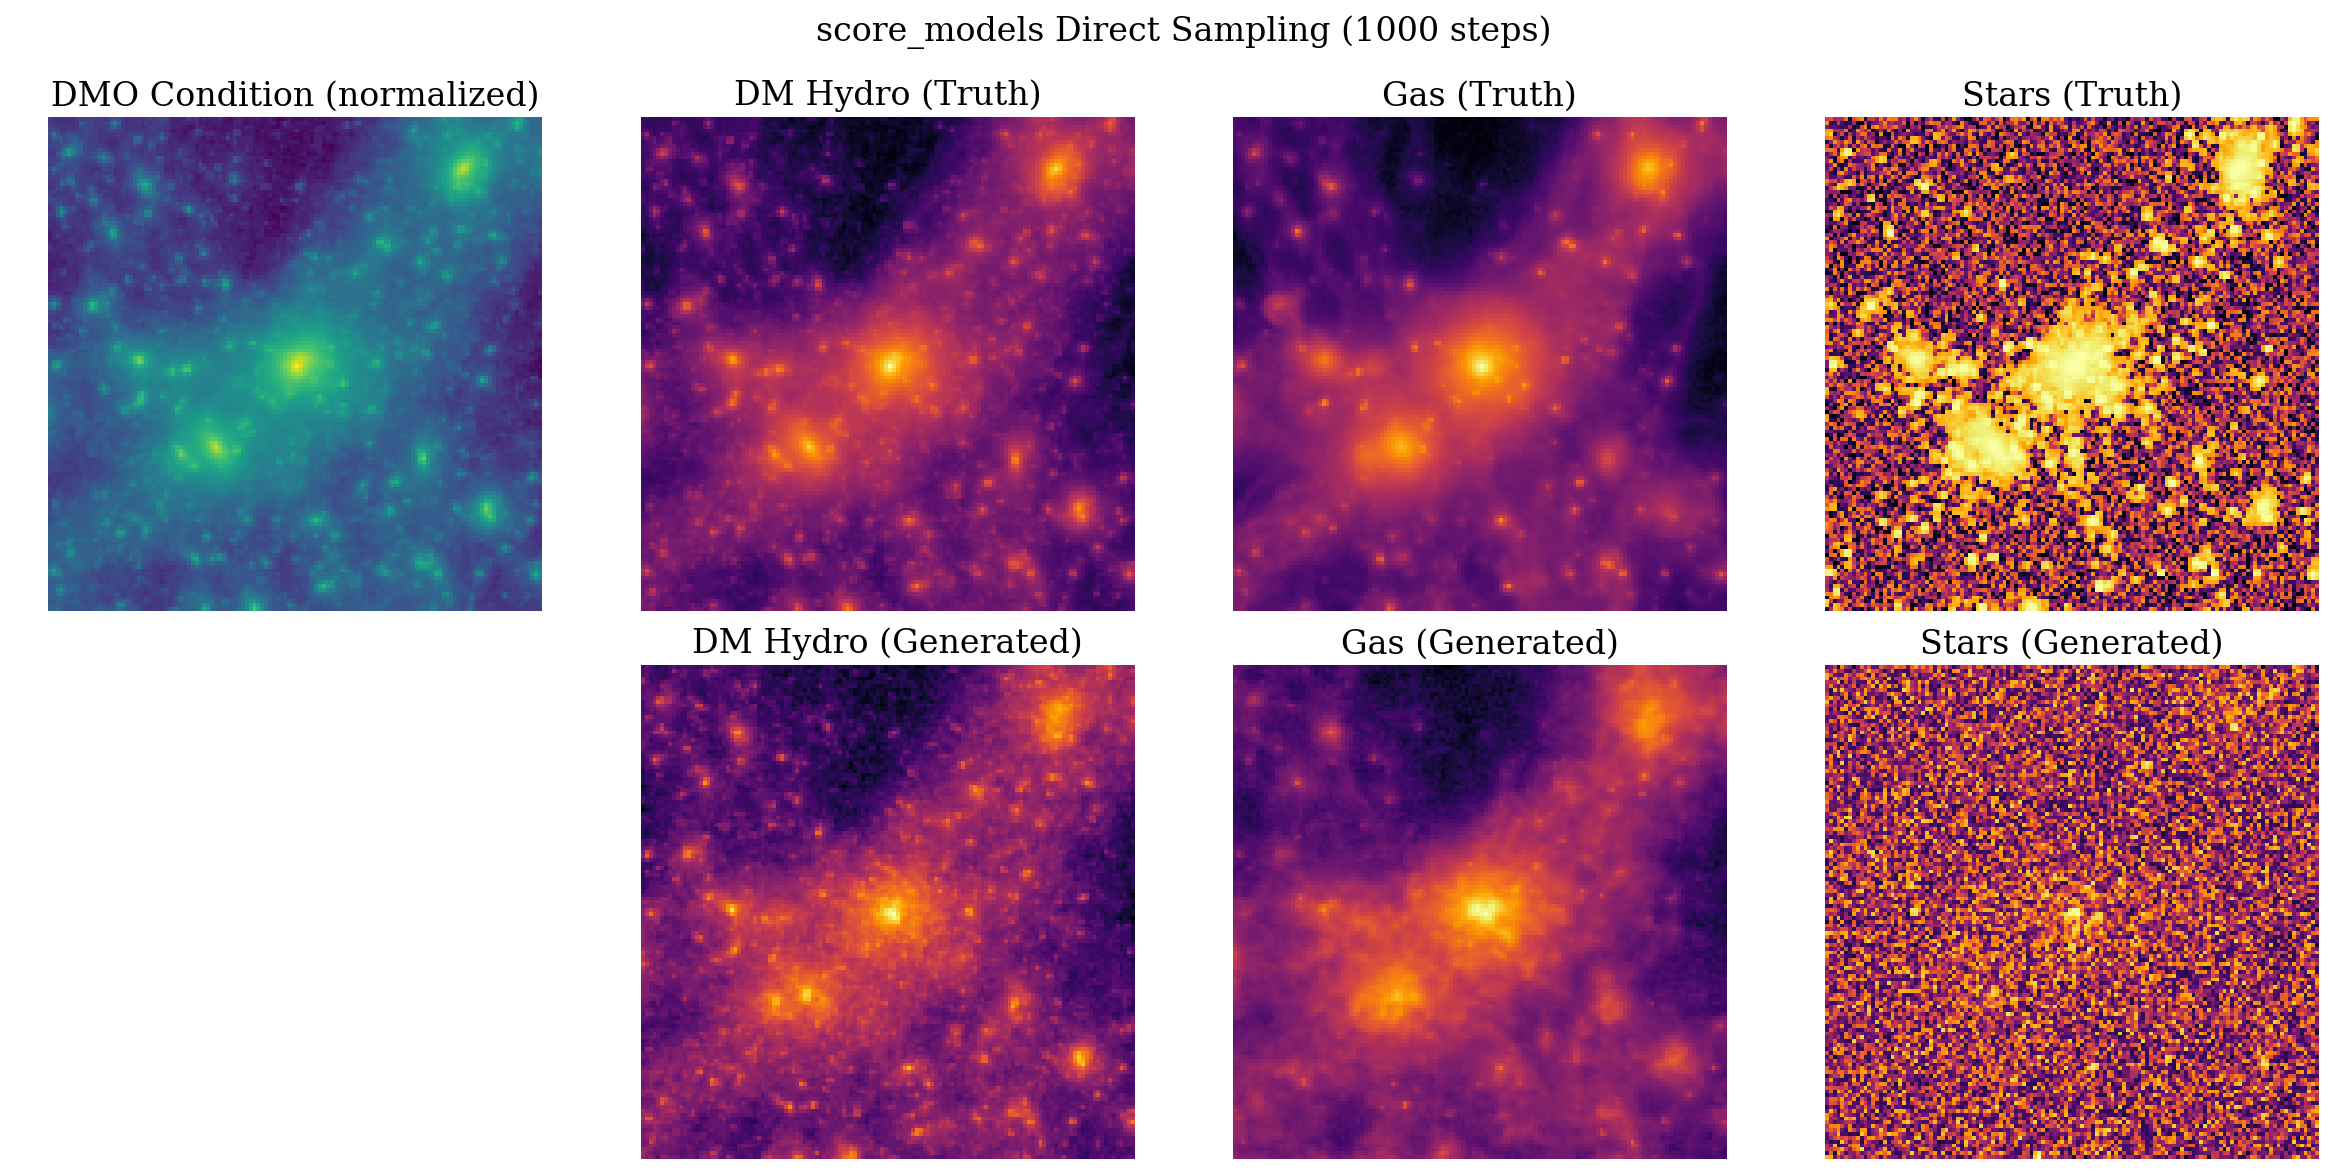


Per-channel statistics (normalized space):
Channel        Truth Mean    Truth Std     Gen Mean      Gen Std
------------------------------------------------------------
DM Hydro           0.8428       1.0257       0.0433       0.6640
Gas                0.3569       1.0937       0.1456       0.6104
Stars              0.4993       0.2857       0.1796       0.2294


In [13]:
# Visualize the generated sample vs ground truth
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

channel_names = ['DM Hydro', 'Gas', 'Stars']
target = selected_targets[sample_idx].numpy()
gen = samples[0].cpu().numpy()  # (3, H, W)
cond_np = selected_conditions[sample_idx, 0].numpy()  # Just DM condition channel

# Row 1: Condition + Ground Truth
axes[0, 0].imshow(cond_np, cmap='viridis')
axes[0, 0].set_title('DMO Condition (normalized)')
axes[0, 0].axis('off')

for ch_idx, ch_name in enumerate(channel_names):
    axes[0, ch_idx+1].imshow(target[ch_idx], cmap='inferno')
    axes[0, ch_idx+1].set_title(f'{ch_name} (Truth)')
    axes[0, ch_idx+1].axis('off')

# Row 2: Empty + Generated
axes[1, 0].axis('off')

for ch_idx, ch_name in enumerate(channel_names):
    im = axes[1, ch_idx+1].imshow(gen[ch_idx], cmap='inferno')
    axes[1, ch_idx+1].set_title(f'{ch_name} (Generated)')
    axes[1, ch_idx+1].axis('off')

plt.suptitle(f'score_models Direct Sampling ({N_SAMPLING_STEPS} steps)', fontsize=16)
plt.tight_layout()
plt.show()

# Print per-channel statistics
print("\nPer-channel statistics (normalized space):")
print(f"{'Channel':<12} {'Truth Mean':>12} {'Truth Std':>12} {'Gen Mean':>12} {'Gen Std':>12}")
print("-" * 60)
for ch_idx, ch_name in enumerate(channel_names):
    print(f"{ch_name:<12} {target[ch_idx].mean():>12.4f} {target[ch_idx].std():>12.4f} "
          f"{gen[ch_idx].mean():>12.4f} {gen[ch_idx].std():>12.4f}")

## Visual Comparison: Input → Generated → Ground Truth

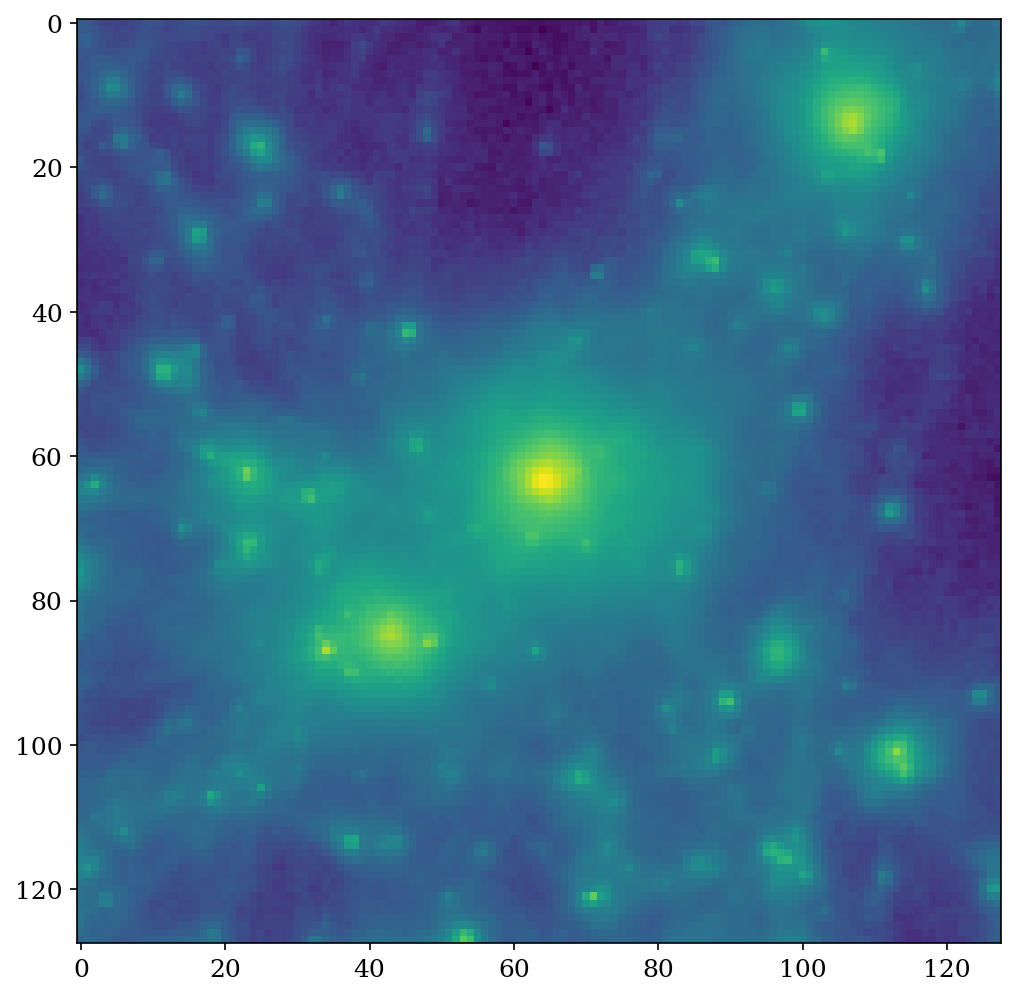

In [14]:
plt.imshow(generated[0,2,1])

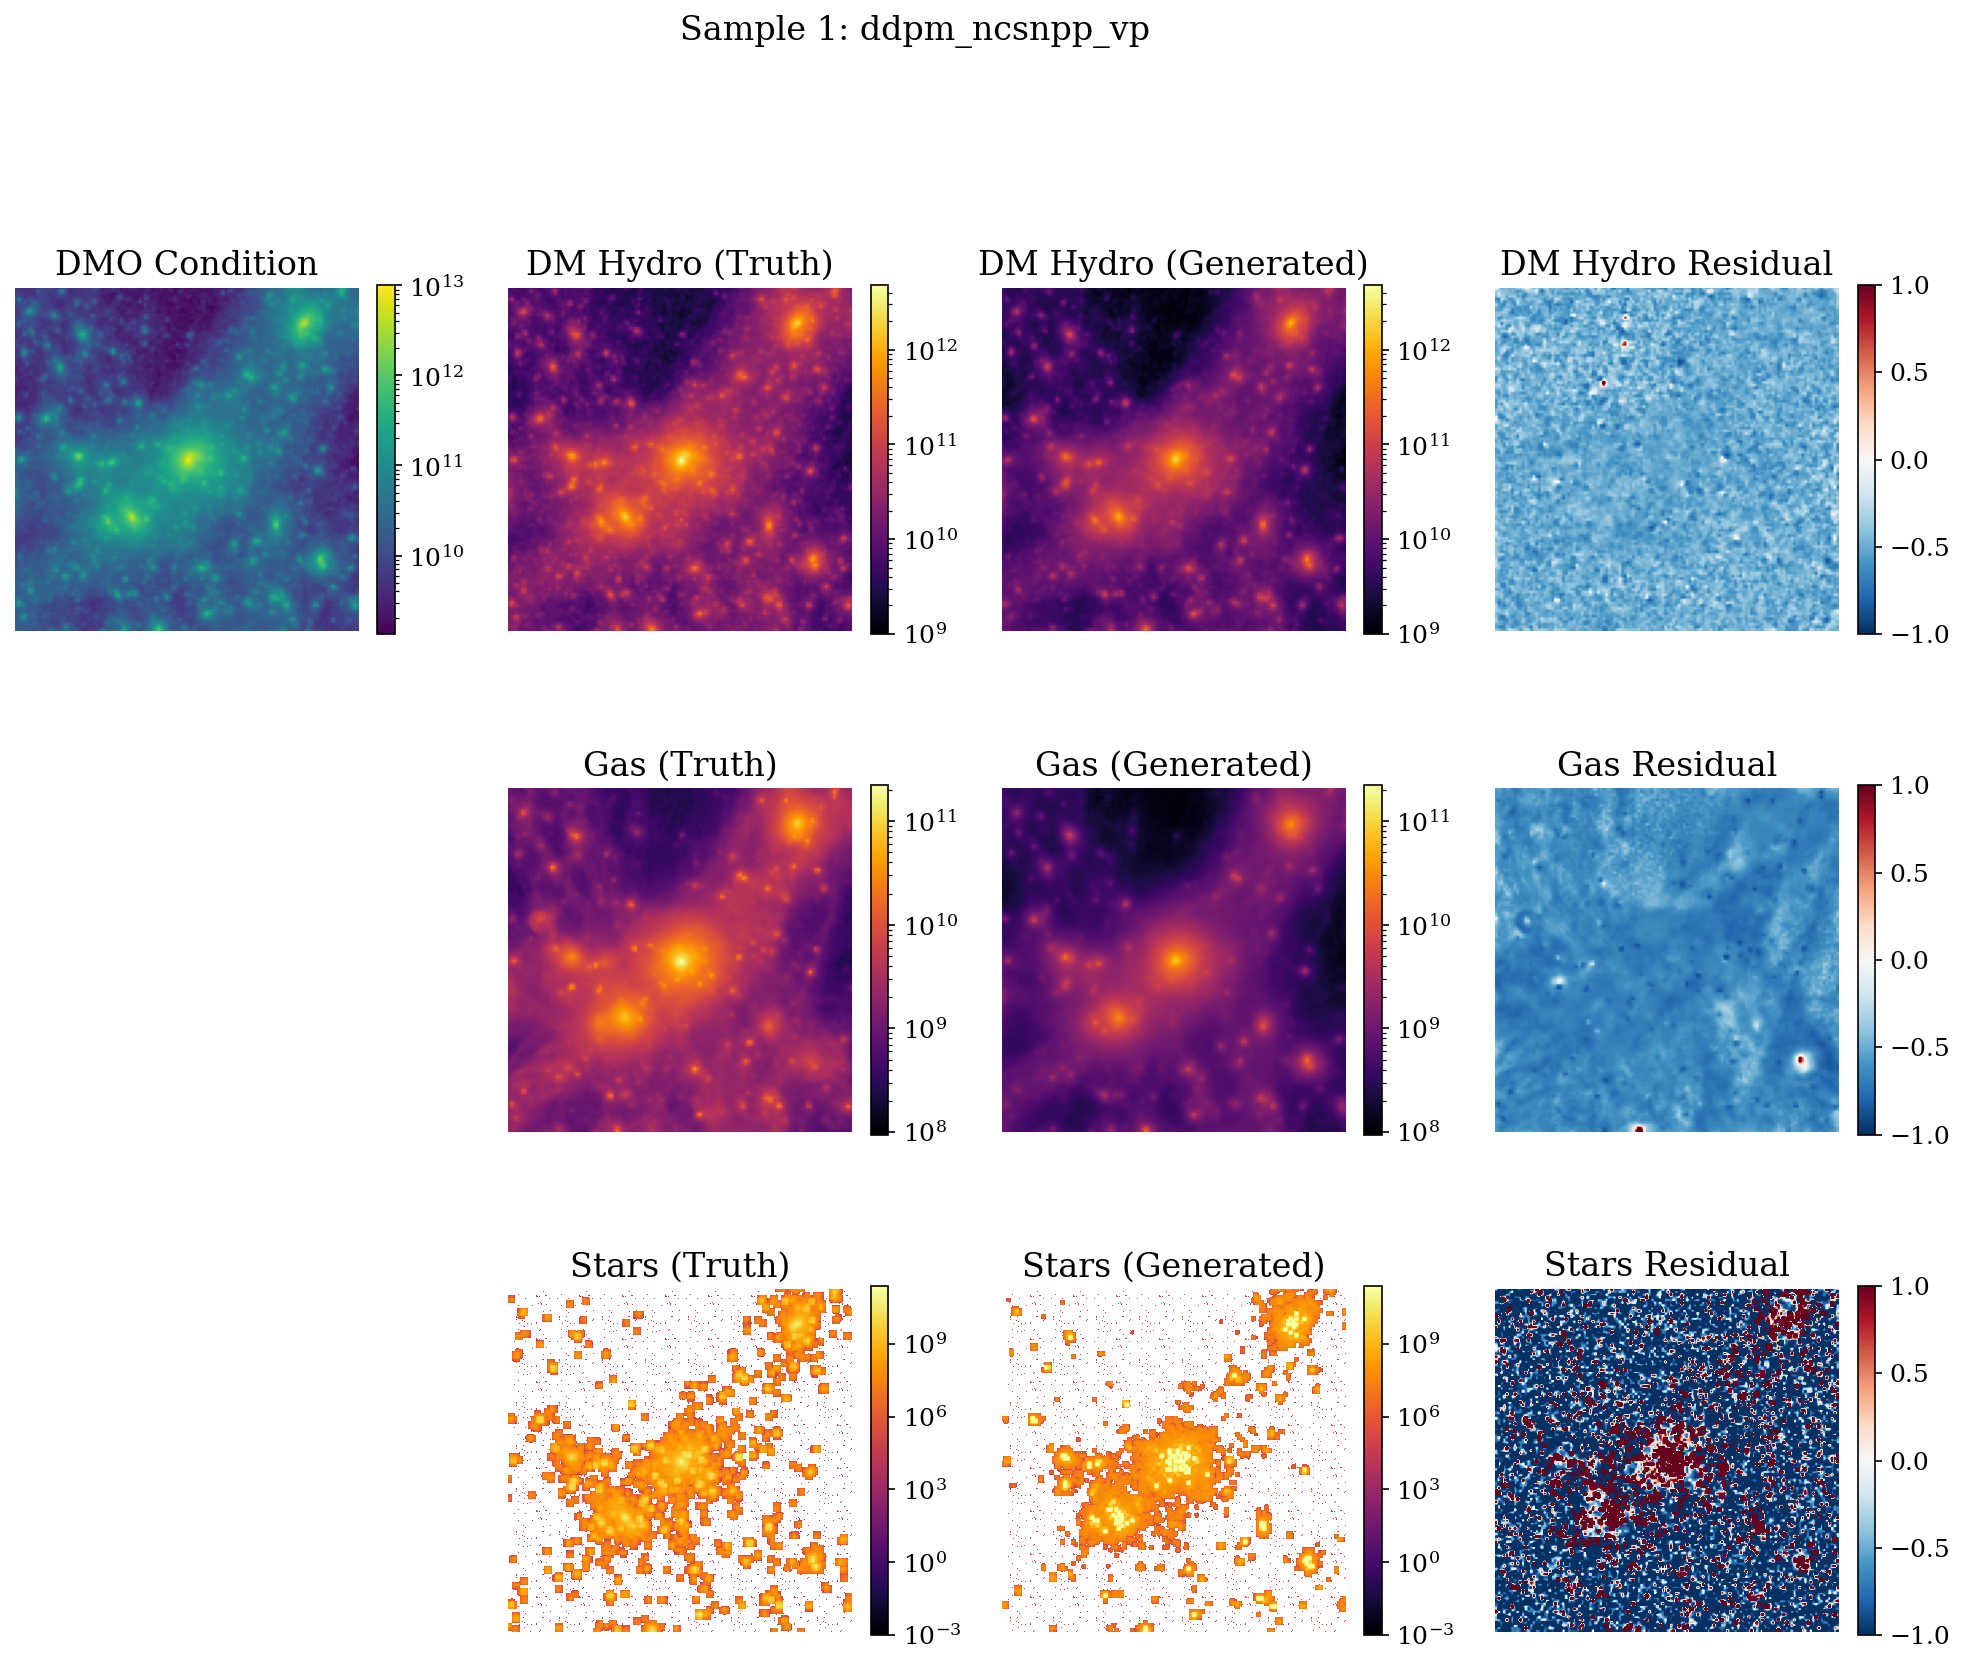


✓ Plotted 1 samples


In [15]:
channel_names = ['DM Hydro', 'Gas', 'Stars']

# Only iterate over actual samples we have
n_samples_to_plot = min(3, len(selected_conditions))

for sample_idx in range(n_samples_to_plot):
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)
    
    # Get data for this sample
    condition = selected_conditions[sample_idx].numpy()
    target = selected_targets[sample_idx].numpy()
    gen_mean = generated[sample_idx].mean(dim=0).numpy()  # Mean over realizations
    gen_std = generated[sample_idx].std(dim=0).numpy()    # Std over realizations
    
    for ch_idx, ch_name in enumerate(channel_names):
        # Unnormalize
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, quantile_transformer)
        
        # Determine color scale
        vmin = max(1e-3, min(target_unnorm.min(), gen_unnorm.min()))
        vmax = max(target_unnorm.max(), gen_unnorm.max())
        norm = LogNorm(vmin=vmin, vmax=vmax)
        
        # Column 1: Condition (only show once, or DM channel)
        if ch_idx == 0:
            ax = fig.add_subplot(gs[ch_idx, 0])
            cond_unnorm = unnormalize_condition(condition[0], norm_stats)
            im = ax.imshow(cond_unnorm, cmap='viridis', norm=LogNorm())
            ax.set_title('DMO Condition')
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046)
        else:
            ax = fig.add_subplot(gs[ch_idx, 0])
            ax.axis('off')
        
        # Column 2: Ground Truth
        ax = fig.add_subplot(gs[ch_idx, 1])
        im = ax.imshow(target_unnorm, cmap='inferno', norm=norm)
        ax.set_title(f'{ch_name} (Truth)')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
        
        # Column 3: Generated (mean)
        ax = fig.add_subplot(gs[ch_idx, 2])
        im = ax.imshow(gen_unnorm, cmap='inferno', norm=norm)
        ax.set_title(f'{ch_name} (Generated)')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
        
        # Column 4: Residual
        ax = fig.add_subplot(gs[ch_idx, 3])
        residual = (gen_unnorm - target_unnorm) / (target_unnorm + 1e-10)
        im = ax.imshow(residual, cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_title(f'{ch_name} Residual')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.suptitle(f'Sample {sample_idx + 1}: {config.model_name}', fontsize=16, y=1.02)
    
    # Save figure
    fig.savefig(str(FIGURE_DIR / f'{config.model_name}_sample_{sample_idx}_comparison.png'))
    plt.show()

print(f"\n✓ Plotted {n_samples_to_plot} samples")

## Radial Density Profiles

Compute azimuthally-averaged density profiles around halo centers.

In [16]:
def compute_radial_profile(image, center=None, n_bins=50, r_max=None):
    """
    Compute azimuthally-averaged radial profile.
    
    Args:
        image: 2D array
        center: (y, x) center coordinates. If None, use image center.
        n_bins: Number of radial bins
        r_max: Maximum radius. If None, use half the image size.
    
    Returns:
        r_bins: Radial bin centers
        profile: Mean value in each radial bin
        profile_std: Standard deviation in each radial bin
    """
    ny, nx = image.shape
    
    if center is None:
        center = (ny // 2, nx // 2)
    
    if r_max is None:
        r_max = min(ny, nx) // 2
    
    # Create coordinate grids
    y, x = np.ogrid[:ny, :nx]
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    
    # Create radial bins
    r_bins = np.linspace(0, r_max, n_bins + 1)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    
    # Compute profile
    profile = np.zeros(n_bins)
    profile_std = np.zeros(n_bins)
    
    for i in range(n_bins):
        mask = (r >= r_bins[i]) & (r < r_bins[i+1])
        if mask.sum() > 0:
            profile[i] = np.mean(image[mask])
            profile_std[i] = np.std(image[mask])
    
    return r_centers, profile, profile_std

In [17]:
N_SAMPLES

5

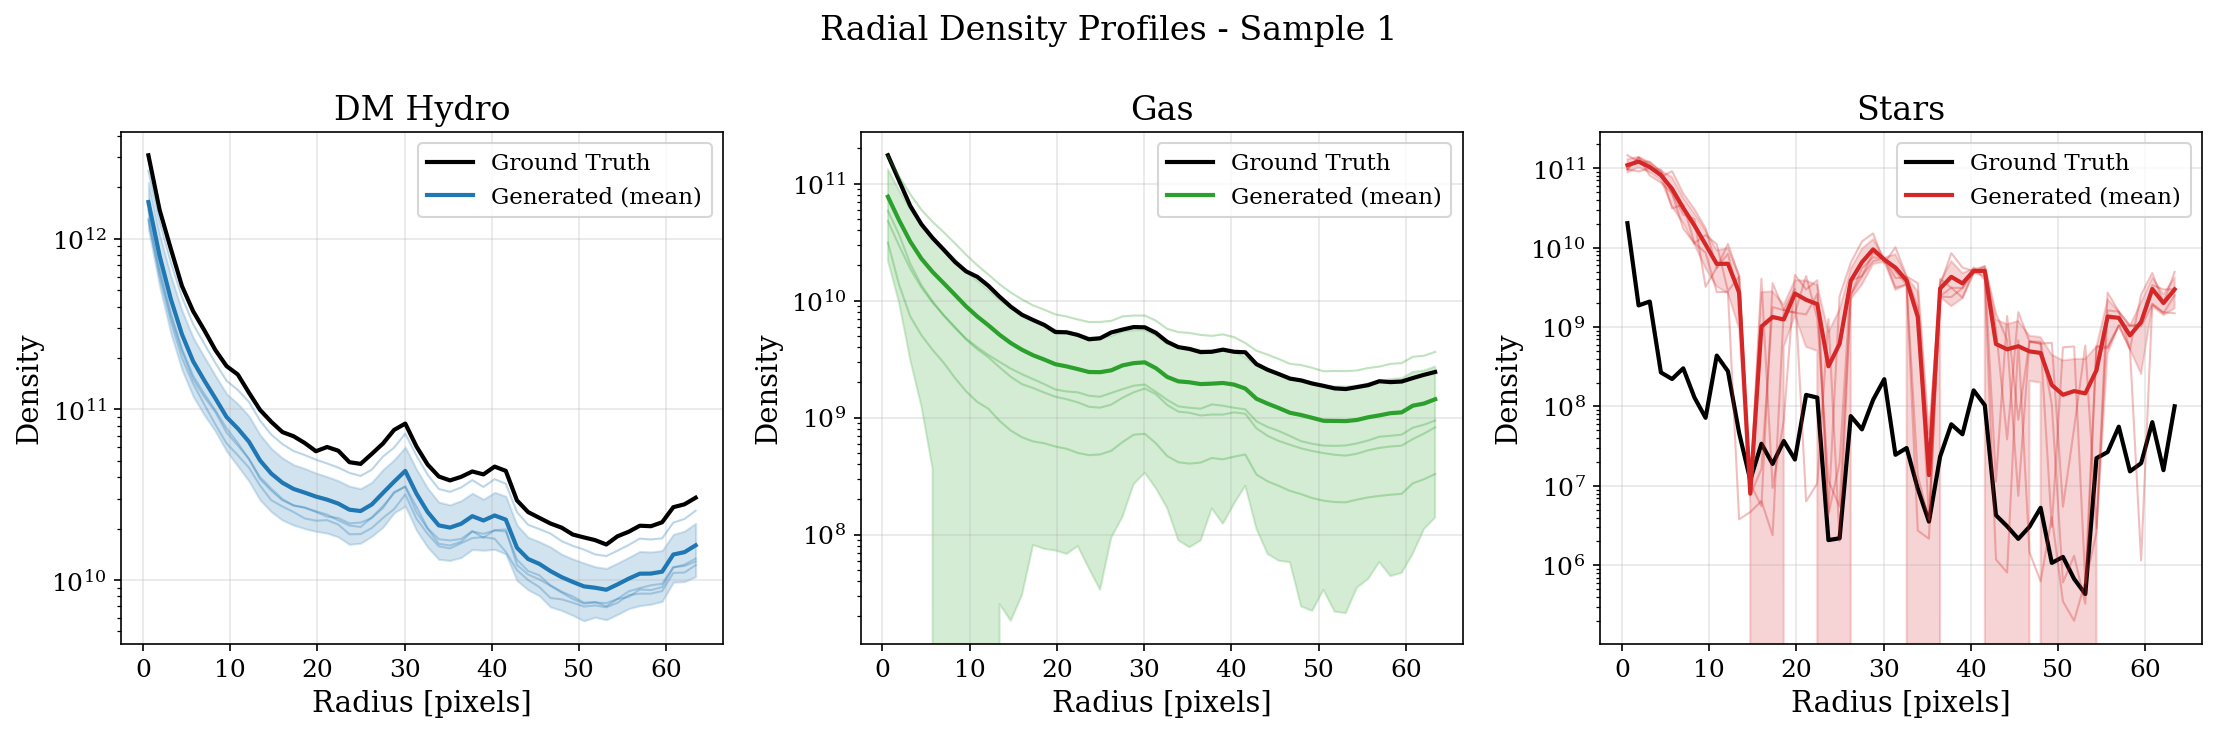

In [18]:
# Compute and plot radial profiles for each sample
channel_colors = ['#1f77b4', '#2ca02c', '#d62728']  # Blue, Green, Red

for sample_idx in range(min(1, N_SAMPLES)):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    target = selected_targets[sample_idx].numpy()
    gen_samples = generated[sample_idx].numpy()  # (N_REALIZATIONS, 3, H, W)
    
    for ch_idx, (ax, ch_name) in enumerate(zip(axes, channel_names)):
        # Unnormalize
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        
        # Ground truth profile
        r, profile_true, _ = compute_radial_profile(target_unnorm)
        ax.plot(r, profile_true, 'k-', linewidth=2, label='Ground Truth')
        
        # Generated profiles (multiple realizations)
        gen_profiles = []
        for real_idx in range(N_REALIZATIONS):
            gen_unnorm = unnormalize_field(gen_samples[real_idx, ch_idx], ch_idx, norm_stats, quantile_transformer)
            r, profile_gen, _ = compute_radial_profile(gen_unnorm)
            gen_profiles.append(profile_gen)
            ax.plot(r, profile_gen, '-', color=channel_colors[ch_idx], 
                   alpha=0.3, linewidth=1)
        
        # Mean generated profile
        gen_profiles = np.array(gen_profiles)
        gen_mean = gen_profiles.mean(axis=0)
        gen_std = gen_profiles.std(axis=0)
        
        ax.plot(r, gen_mean, '-', color=channel_colors[ch_idx], 
               linewidth=2, label='Generated (mean)')
        ax.fill_between(r, gen_mean - gen_std, gen_mean + gen_std, 
                       color=channel_colors[ch_idx], alpha=0.2)
        
        ax.set_xlabel('Radius [pixels]')
        ax.set_ylabel('Density')
        ax.set_title(ch_name)
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Radial Density Profiles - Sample {sample_idx + 1}', fontsize=16)
    plt.tight_layout()
    
    fig.savefig(str(FIGURE_DIR / f'{config.model_name}_sample_{sample_idx}_profiles.png'))
    plt.show()

## Profile Residuals Analysis

In [19]:
# Aggregate profiles across all samples
all_residuals = {ch: [] for ch in channel_names}

for sample_idx in range(min(1, N_SAMPLES)):
    target = selected_targets[sample_idx].numpy()
    gen_mean = generated[sample_idx].mean(dim=0).numpy()
    
    for ch_idx, ch_name in enumerate(channel_names):
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, quantile_transformer)
        
        r, profile_true, _ = compute_radial_profile(target_unnorm)
        _, profile_gen, _ = compute_radial_profile(gen_unnorm)
        
        residual = (profile_gen - profile_true) / (profile_true + 1e-10)
        all_residuals[ch_name].append(residual)

# Convert to arrays
for ch_name in channel_names:
    all_residuals[ch_name] = np.array(all_residuals[ch_name])

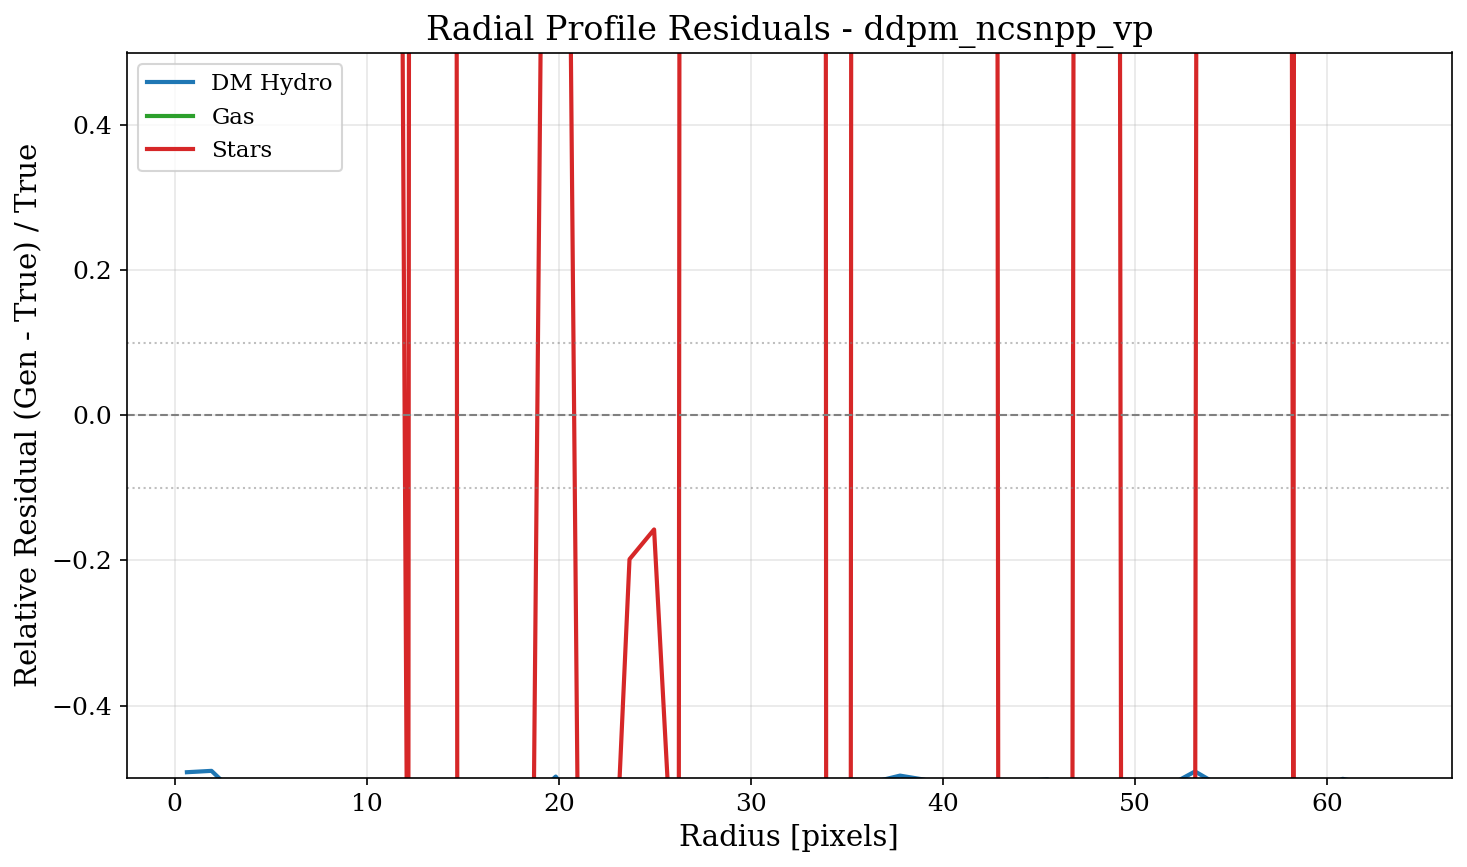

In [20]:
# Plot aggregated residuals
fig, ax = plt.subplots(figsize=(10, 6))

for ch_idx, (ch_name, color) in enumerate(zip(channel_names, channel_colors)):
    residuals = all_residuals[ch_name]
    mean_res = residuals.mean(axis=0)
    std_res = residuals.std(axis=0)
    
    ax.plot(r, mean_res, '-', color=color, linewidth=2, label=ch_name)
    ax.fill_between(r, mean_res - std_res, mean_res + std_res, 
                   color=color, alpha=0.2)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax.axhline(y=0.1, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.axhline(y=-0.1, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Radius [pixels]')
ax.set_ylabel('Relative Residual (Gen - True) / True')
ax.set_title(f'Radial Profile Residuals - {config.model_name}')
ax.set_ylim(-0.5, 0.5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(str(FIGURE_DIR / f'{config.model_name}_profile_residuals.png'))
plt.show()

## Summary Statistics

In [ ]:
print(f"\n{'='*60}")
print(f"Validation Summary: {config.model_name}")
print(f"{'='*60}\n")

print(f"Model type: {detected_type}")
print(f"Test samples evaluated: {N_SAMPLES}")
print(f"Realizations per sample: {N_REALIZATIONS}")
if detected_type in ['ddpm', 'interpolant']:
    print(f"Sampling steps: {SAMPLING_STEPS}")
print()

print("Mean Absolute Relative Error (by channel):")
for ch_name in channel_names:
    residuals = all_residuals[ch_name]
    mare = np.abs(residuals).mean()
    print(f"  {ch_name}: {mare:.4f} ({mare*100:.2f}%)")

print("\nBias (by channel):")
for ch_name in channel_names:
    residuals = all_residuals[ch_name]
    bias = residuals.mean()
    print(f"  {ch_name}: {bias:+.4f} ({bias*100:+.2f}%)")


Validation Summary: ddpm_ncsnpp_vp

Model type: ddpm
Test samples evaluated: 5
Realizations per sample: 4
DDPM sampling steps: 1000

Mean Absolute Relative Error (by channel):
  DM Hydro: 0.5164 (51.64%)
  Gas: 0.6686 (66.86%)
  Stars: 28.9892 (2898.92%)

Bias (by channel):
  DM Hydro: -0.5164 (-51.64%)
  Gas: -0.6686 (-66.86%)
  Stars: +28.3700 (+2837.00%)


## Compare Multiple Models (Optional)

In [ ]:
# ============================================================================
# MODEL COMPARISON - Set to True to enable
# ============================================================================

COMPARE_MODELS = False

if COMPARE_MODELS:
    from vdm.vdm_model_triple import LightTripleVDM
    
    # List of configs to compare: (config_file, label, model_type)
    # model_type can be: 'clean', 'triple', or 'ddpm'
    CONFIGS_TO_COMPARE = [
        ('clean_vdm_aggressive_stellar.ini', 'Clean 3ch', 'clean'),
        ('clean_vdm_triple.ini', 'Triple', 'triple'),
        # Uncomment to include DDPM when trained:
        # ('ddpm.ini', 'DDPM NCSNpp', 'ddpm'),
    ]
    
    comparison_residuals = {}
    
    for config_file, label, mtype in CONFIGS_TO_COMPARE:
        config_path = PROJECT_ROOT / 'configs' / config_file
        if not config_path.exists():
            print(f"Config not found: {config_path}")
            continue
            
        print(f"\nLoading {label}...")
        cfg = ConfigLoader(str(config_path), verbose=False)
        
        # Skip if no checkpoint exists
        if cfg.best_ckpt is None:
            print(f"  No checkpoint found, skipping...")
            continue
        
        # Resolve quantile path
        if hasattr(cfg, 'quantile_path') and cfg.quantile_path is not None:
            if not os.path.isabs(cfg.quantile_path):
                cfg.quantile_path = str(PROJECT_ROOT / cfg.quantile_path)
        
        # Load model based on type - ModelManager handles all types now
        _, mdl = ModelManager.initialize(cfg, verbose=False, skip_data_loading=True)
        mdl = mdl.to(DEVICE)
        mdl.eval()
        
        # For DDPM models, set sampling steps
        if mtype == 'ddpm' and hasattr(mdl, 'sampling_steps'):
            mdl.sampling_steps = DDPM_SAMPLING_STEPS
            print(f"  Using {DDPM_SAMPLING_STEPS} sampling steps")
        
        # Generate predictions
        with torch.no_grad():
            gen = sample(mdl, selected_conditions, batch_size=N_REALIZATIONS,
                        conditional_params=selected_params)
        
        # Compute residuals
        residuals = {ch: [] for ch in channel_names}
        for sample_idx in range(N_SAMPLES):
            target = selected_targets[sample_idx].numpy()
            gen_mean = gen[sample_idx].mean(dim=0).numpy()
            
            for ch_idx, ch_name in enumerate(channel_names):
                target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
                gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, quantile_transformer)
                
                r, profile_true, _ = compute_radial_profile(target_unnorm)
                _, profile_gen, _ = compute_radial_profile(gen_unnorm)
                
                residual = (profile_gen - profile_true) / (profile_true + 1e-10)
                residuals[ch_name].append(residual)
        
        comparison_residuals[label] = {ch: np.array(v) for ch, v in residuals.items()}
        print(f"  ✓ Generated {len(gen)} samples")
    
    # Plot comparison
    if comparison_residuals:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        for ch_idx, (ax, ch_name) in enumerate(zip(axes, channel_names)):
            for label, res_dict in comparison_residuals.items():
                residuals = res_dict[ch_name]
                mean_res = residuals.mean(axis=0)
                ax.plot(r, mean_res, '-', linewidth=2, label=label)
            
            ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
            ax.set_xlabel('Radius [pixels]')
            ax.set_ylabel('Relative Residual')
            ax.set_title(ch_name)
            ax.set_ylim(-0.5, 0.5)
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.suptitle('Model Comparison: Profile Residuals', fontsize=16)
        plt.tight_layout()
        fig.savefig(str(FIGURE_DIR / 'model_comparison_profiles.png'))
        plt.show()
    else:
        print("\nNo models with checkpoints found for comparison.")